In [1]:
import os
from sys import stdout
from openmm import *
from openmm.app import *
from openmm.unit import *

import nglview as ngl
import pytraj as pt
import numpy as np
import matplotlib.pyplot as plt

# Enhanced sampling with OpenMM and Adaptive Sampling

In this short tutorial we will show how to use the adaptive sampling package together with OpenMM.

We will run test simulations on the mimimal "protein" alanine-dipeptide. Data files for this notebook were taken from the OpenMM test systems.

*    alanine-dipeptide.pdb (All-atom PDB file.)
*    alanine-dipeptide.crd (AMBER input coordinates)
*    alanine-dipeptide.prmtop (AMBER parameters and topology)

A thorough discussion of the alanine dipeptide system can be found [here](https://doi.org/10.1073/pnas.100127697).

For this tutorial we will use the following programm packages:
*    OpenMM for molecular simulation: https://openmm.org/
*    PyTraj for trajectory analysis: https://amber-md.github.io/pytraj/latest/index.html
*    Nglview for molecular visualisation: https://github.com/nglviewer/nglview

We begin with a minimal example of an unbiased OpenMM simulation of alanine dipeptide in vacuum.

In [2]:
def run(nsteps: int=1000, T: float=300.0, dcd_freq: int=10, out_freq: int=10):
    
    # load system topology and coordinates from AMBER format
    prmtop = AmberPrmtopFile(f"../data/alanine-dipeptide.prmtop")
    crd = AmberInpcrdFile(f"../data/alanine-dipeptide.crd")

    # create the system and integrator 
    system = prmtop.createSystem(
        nonbondedMethod=NoCutoff,
    )
    platform = Platform.getPlatformByName('CPU')
    integrator = LangevinIntegrator(T * kelvin, 1.0 / picoseconds, 2.0 * femtosecond)

    # setup an simulation and run MD for nsteps
    simulation = Simulation(prmtop.topology, system, integrator, platform)
    simulation.context.setPositions(crd.positions)
    simulation.context.setVelocitiesToTemperature(T)
    simulation.reporters.append(DCDReporter('alanine-dipeptide-test.dcd', dcd_freq))
    simulation.reporters.append(StateDataReporter(
        stdout, 
        out_freq,
        step=True,
        time=True,
        potentialEnergy=True,
        kineticEnergy=True,
        totalEnergy=True,
        temperature=True,
        separator='\t')
    )
    simulation.step(nsteps)

In [3]:
run(nsteps=100)

#"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Kinetic Energy (kJ/mole)"	"Total Energy (kJ/mole)"	"Temperature (K)"
10	0.020000000000000004	-73.27194656017015	41.2150890082013	-32.05685755196885	157.3662164543474
20	0.04000000000000002	-63.772596078265856	32.76320708757695	-31.009388990688905	125.09549445001313
30	0.06000000000000004	-78.90445636300151	51.44876176490845	-27.455694598093068	196.44011877770467
40	0.08000000000000006	-81.51074164533324	55.34429446312296	-26.166447182210284	211.31392486533022
50	0.10000000000000007	-69.18861608952793	43.91462905803283	-25.273987031495096	167.67351929007424
60	0.12000000000000009	-78.68154810535968	60.95261366475674	-17.72893444060294	232.72744099903932
70	0.1400000000000001	-77.42327625885716	61.79544956528494	-15.627826693572217	235.94553175050225
80	0.16000000000000011	-62.84578323816787	43.11833662479518	-19.727446613372692	164.63313940917914
90	0.18000000000000013	-65.74837751999192	43.52612976826933	-22.22224775172259	166.190162956

We can visualize the trajectory using pytraj and nglview. 

Alanine dipeptide is a popular testsystem for enhanced sampling algorithms because it is a minimal example for sampling challanges that are posed by many biological systems. The slow motions of the molecule are largely governed by the $\psi$ (backbone N-C-C-N) and $\phi$ (backbone C-N-C-C) diherals. Below atoms involved in this collective variables (CVs) are shown in ball and stick representation, while other atoms are transperent.  

In [4]:
traj = pt.iterload("alanine-dipeptide-test.dcd", top="../data/alanine-dipeptide.pdb")

view = ngl.show_pytraj(traj)
view.clear_representations()
view.add_ball_and_stick('@6,8,14,16', opacity=1.0) # CV atoms of phi torsion
view.add_ball_and_stick('@4,6,8,14', opacity=1.0)  # CV atoms of psi torsion
#view.add_ball_and_stick('@1,4,6,8', opacity=1.0)   # CV atoms of theta torsion

view.add_licorice(opacity=0.5)
view

NGLWidget(max_frame=9)

# Enhanced sampling of $\psi$ with WTM-eABF

In the following example we will apply the WTM-eABF sampling algorithm to enhance sampling along the $\psi$ angle. Note, that this is a suboptimal CV and there is still an orthogonal free energy barrier along the $\phi$ torsion. 

In [5]:
from adaptive_sampling.sampling_tools import *
from adaptive_sampling.interface.interface_openmm import AdaptiveSamplingOpenMM

# ------------------------------------------------------------------------------------
# define collective variables
cv_atoms_psi    = [6, 8, 14, 16]  # backbone N-C-C-N torsion
cv_atoms_phi    = [4, 6, 8, 14]   # backbone C-N-C-C torsion
minimum         = -180.0          # minimum of the CV
maximum         = 180.0           # maximum of the CV
bin_width       = 5.0             # bin with along the CV

collective_var_psi = [["torsion", cv_atoms_psi, minimum, maximum, bin_width]]
#collective_var_phi = [["torsion", cv_atoms_phi, minimum, maximum, bin_width]]

# ------------------------------------------------------------------------------------
# Setup OpenMM
prmtop = AmberPrmtopFile(f"../data/alanine-dipeptide.prmtop")
crd = AmberInpcrdFile(f"../data/alanine-dipeptide.crd")
system = prmtop.createSystem(
    nonbondedMethod=NoCutoff,
    constraints=HBonds,
)

# remove center of mass motion
cmm_force = CMMotionRemover()
cmm_force.setFrequency(10)
system.addForce(cmm_force)

# Initialize the `AdaptiveSamplingOpenMM` interface to couple the OpenMM simulaiton to an bias potential
# the Openmm `simulation` object is set up internally, but can still be modified by calling `the_md.simulation`
the_md = AdaptiveSamplingOpenMM(
    crd.positions,
    prmtop.topology,
    system,
    dt=2.0,                                       # timestep in fs
    equil_temp=300.0,                             # temperature of simulation
    langevin_damping=1.0,                         # langevin damping in 1/ps
    cv_atoms=np.unique(cv_atoms_phi+cv_atoms_psi) # specifying CV atoms significantly speeds up simulation of large systems, as the bias force will only be calculated for those
)
the_md.integrator.setConstraintTolerance(0.0001)

# Append OpenMM reporters to simulation for output 
the_md.simulation.reporters.append(DCDReporter('alanine-dipeptide.dcd', 100))
the_md.simulation.reporters.append(StateDataReporter(
    stdout, 
    1000,
    step=True,
    time=True,
    potentialEnergy=True,
    kineticEnergy=True,
    totalEnergy=True,
    temperature=True,
    speed=False,
    separator='\t')
)

# --------------------------------------------------------------------------------------
# Setup the sampling algorithm
eabf_ext_sigma    = 5.0     # thermal width of coupling between CV and extended variable 
eabf_ext_mass     = 100.0   # mass of extended variable 
abf_nfull         = 500     # number of samples per bin when abf force is fully applied
mtd_hill_height   = 0.1     # MtD hill height    
mtd_hill_std      = 15.0    # MtD hill width
mtd_well_tempered = 1000.0  # Well-tempered temperature
mtd_frequency     = 100     # frequency of hill creation

the_bias = WTMeABF(
    eabf_ext_sigma, 
    eabf_ext_mass, 
    mtd_hill_std,
    mtd_hill_std,
    the_md, 
    collective_var_psi,     # collective variable
    output_freq=1000,       # frequency of writing outputs
    f_conf=0.0,             # confinement force of CV at boundaries
    nfull=abf_nfull,        
    equil_temp=300.0,       # equilibrium temperature of simulation
    well_tempered_temp=mtd_well_tempered,
    hill_drop_freq=mtd_frequency,
    force_from_grid=True,   # accumulate metadynamics force and bias on grid
    kinetics=True,          # calculate importent metrics to get accurate kinetics
    verbose=False,          # print verbose output
)
the_md.set_sampling_algorithm(the_bias) # to take affect the sampling algorithm has to set in the MD interface

In [6]:
# Warning: this may take a while!
if True:
    os.system("rm CV_traj.dat wtmeabf.out")
the_md.run(nsteps=500000) # 500000 * 2 fs = 1 ns

#"Step"	"Time (ps)"	"Potential Energy (kJ/mole)"	"Kinetic Energy (kJ/mole)"	"Total Energy (kJ/mole)"	"Temperature (K)"
1000	2.0000000000000013	-16.971310280132343	80.19415452501248	63.222844244880136	378.24077746602103
2000	3.999999999999781	-22.44604851416826	75.305825114939	52.859776600770736	355.18466411801484
3000	5.999999999999561	-63.88889826641629	79.00939939871216	15.120501132295871	372.652805340959
4000	7.999999999999341	-36.90542702742398	88.7717227376392	51.86629571021521	418.6974178374815
5000	10.000000000000009	-57.592020858958904	55.67158292411657	-1.920437934842333	262.5785249898005
6000	12.000000000000677	-48.161796553507685	45.88483477919187	-2.276961774315815	216.41871135842308
7000	14.000000000001345	-47.95231718935882	77.81634983568402	29.8640326463252	367.0257119829947
8000	16.00000000000201	-57.244555923332705	51.20534246740192	-6.039213455930785	241.51322075779376
9000	18.000000000000902	-61.60557863729879	79.11369855940013	17.508119922101343	373.14473889723047
1

# Analysis of Results

### Visualising the trajectory

In [7]:
traj = pt.iterload("alanine-dipeptide.dcd", top="../data/alanine-dipeptide.pdb")

view = ngl.show_pytraj(traj)
view.clear_representations()
view.add_ball_and_stick('@6,8,14,16', opacity=1.0) # CV atoms of phi torsion
view.add_ball_and_stick('@4,6,8,14', opacity=1.0)  # CV atoms of psi torsion
#view.add_ball_and_stick('@1,4,6,8', opacity=1.0)   # CV atoms of theta torsion

view.add_licorice(opacity=0.5)
view

NGLWidget(max_frame=4999)

In [8]:
cv_traj = np.loadtxt('CV_traj.dat', skiprows=1, usecols=[0,1,2,3,4])

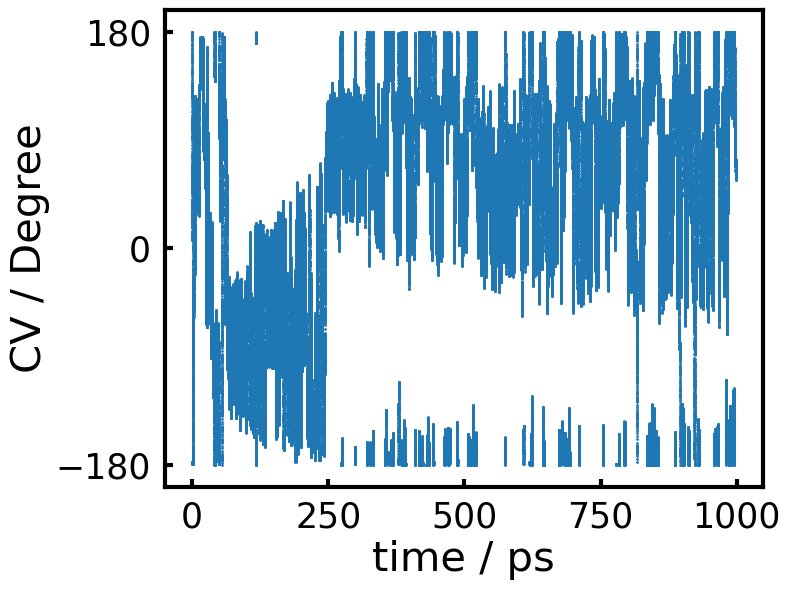

In [9]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))
axs.scatter(cv_traj[:,0]/1000, cv_traj[:,1], s=1)
axs.set_yticks([-180,0,180])
axs.set_xlabel('time / ps', fontsize=30)
axs.set_ylabel('CV / Degree', fontsize=30)
axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

### Use the MBAR estimator to compute ensamble properties

Now we will use the MBAR estimator to calculate the unbiased weights of simulation frames. From those we compute an periodic PMF along $\psi$.

In [10]:
from adaptive_sampling.processing_tools import mbar
ext_sigma = 5.0    # thermal width of coupling between CV and extended variable 

# grid for free energy profile can be different than during sampling
minimum   = -180.0    
maximum   = 180.0    
bin_width = 5.0  
grid = np.arange(minimum, maximum, bin_width)

cv = cv_traj[:,1]  # trajectory of collective variable
la = cv_traj[:,2]  # trajectory of extended system

# run MBAR and compute free energy profile and probability density from statistical weights
traj_list, indices, meta_f = mbar.get_windows(grid, cv, la, ext_sigma, equil_temp=300.0)

exp_U, frames_per_traj = mbar.build_boltzmann(
    traj_list, 
    meta_f, 
    equil_temp=300.0,
    periodicity=[-180.0,180.0],
)

weights = mbar.run_mbar(
    exp_U,
    frames_per_traj,
    max_iter=10000,
    conv=1.0e-4,
    conv_errvec=1.0,
    outfreq=100,
    device='cpu',
)

pmf_mbar, rho_mbar = mbar.pmf_from_weights(grid, cv[indices], weights, equil_temp=300.0)

Start of the self-consistent iteration.
Iter    1:	Conv=  0.2271737433	Conv_errvec=    764.016985
Iter  100:	Conv=  0.0069689756	Conv_errvec=     82.962539
Iter  200:	Conv=  0.0045990897	Conv_errvec=     29.383858
Iter  300:	Conv=  0.0021946738	Conv_errvec=     12.612571
Iter  400:	Conv=  0.0009979087	Conv_errvec=      5.588990
Iter  500:	Conv=  0.0004523660	Conv_errvec=      2.491007
Iter  600:	Conv=  0.0002056388	Conv_errvec=      1.112819
Converged after 692 iterations!
Max error vector:       0.531123


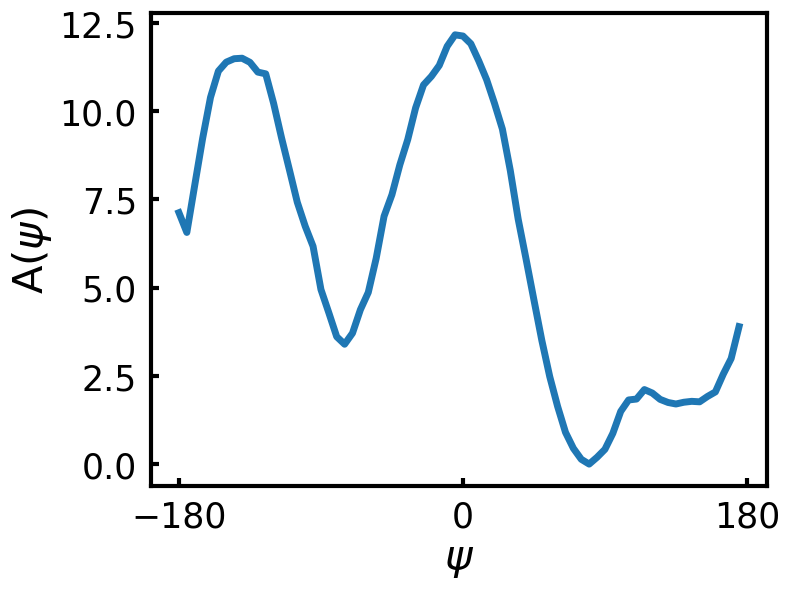

In [11]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))

#plt.plot(np.degrees(the_bias.grid[0]), the_bias.pmf[0], linewidth=5)
plt.plot(grid, pmf_mbar-pmf_mbar.min(), linewidth=5)

axs.set_xlabel(r'$\psi$', fontsize=30)
axs.set_ylabel(r'A($\psi$)', fontsize=30)
axs.set_xticks([-180,0,180])
axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

### Sampling of the ($\psi$, $\phi$) plane (Ramadachan plot)

The above PMF is largely characterised by two distict minima, which are refered to as $C_\mathrm{7eq}$ and $C_\mathrm{ax}$. Below those are marked in the $(\psi,\phi)$ plane together with samples of the trajectory.

In [12]:
phi, psi = pt.multidihedral(traj, 'phi psi')

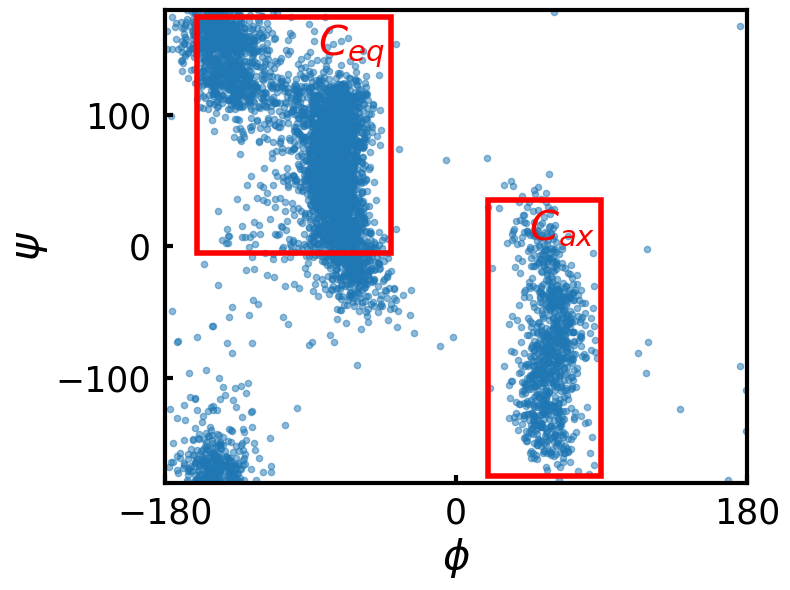

In [13]:
from matplotlib.patches import Rectangle
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))

axs.scatter(phi, psi, alpha=0.5, s=20)

# markup minima
fontdict = {'family': 'serif', 'color':  'red', 'weight': 'normal', 'size': 30,}
axs.add_patch(Rectangle((-160,-5),120,180, edgecolor='red', facecolor='none', lw=4))
axs.add_patch(Rectangle((20,-175),70,210, edgecolor='red', facecolor='none', lw=4))
axs.text(-85,145,r'$C_{7eq}$', fontdict=fontdict)
axs.text(45,5,r'$C_{ax}$', fontdict=fontdict)

# formatting
axs.set_xlabel(r'$\phi$', fontsize=fontdict['size'])
axs.set_ylabel(r'$\psi$', fontsize=fontdict['size'])
axs.set_xlim([-180,180])
axs.set_ylim([-180,180])
axs.set_xticks([-180,0,180])
axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()